# FS20C7 - Recommendations im Detailhandel
### Autoren: Eugen Cuic, Lukas Reber
### Datum, Ort: 05.06.2020, FHNW Brugg-Windisch
### Studiengang: BSc Data Science

Das vorliegende Python Notebook wurde im Rahmen der Challenge "Recommendations im Detailshandel" im Frühlingssemester 2020 erarbeitet. Das Notebook funktioniert als User Interface, womit der/die Anwender*in jede Zelle sequenziell ausführen kann und die entsprechende Resultate angezeigt bekommt. Die Funktionen wurden in die jeweiligen Python Module ausgelagert. Die Funktionen sind mittels DocString beschrieben und können mit dem Befehl help(Name_der_Funktion) aufgerufen werden. 

Weiterführende Informationen zur Thema "Recommender Systems" und zum Aufbau des Programmcodes, sowie die Resultate der Evaluierung sind dem Dokument "FS20C7_Bericht_Cuic_Reber" zu entnehmen.

***

### Inhaltsverzeichnis:
 - Explorative Datenanalyse
 - Datenaufbereitung
   - Datenreduktion
   - Matrixerstellung
   - Split Train / Test Set
- Recommender Building
   - Memory-Based Recommender
   - Model Based Recommender
- Evaluation
 

In [1]:
# Import der Python Packages
import numpy as np
import pandas as pd

# Import der selbst erstellten Pyhton Module
from explorative_analysis import *
from datenaufbereitung import *
from matrixerstellung import *
from evaluation import *
from recommender_ubcf import *

# Explorative Datenanalyse

In [2]:
# Es wurde bewusst darauf verzichtet, beim Einlesen der Daten nur ein Subset der Attribute zu berücksichtigen. Da für den EDA Teil potentiell alle Attribute relevant sein können. Im Kontext des Recommender Buildings, könnte jedoch auf die meisten Werte verzichtet werden

data = pd.read_csv ("Recommender4Retail.csv", index_col=[0]) #nrows=1000000: kann für Testzwecke gesetzt werden, wenn nicht der gesamte Datensatz eingelesen werden soll
data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
1,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,beverages,soft drinks
2,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,dairy eggs,soy lactosefree
3,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,snacks,popcorn jerky
4,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,snacks,popcorn jerky
5,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,household,paper goods


Description of the attributes (According to https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)

- order_id: order identifier
- user_id: user identifier
- eval_set: which evaluation set this order belongs in (we only have Prior and Train) - no test?
- order_number: the order sequence number for this user (1 = first, n = nth)
- order_dow: the day of the week the order was placed on
- order_hour_of_day: the hour of the day the order was placed on
- days_since_prior_order: days since the last order, capped at 30 (with NaNs for order_number = 1)
- product_id: product identifier
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise
- product_name: name of the product
- aisle_id: aisle identifier
- department_id: department identifier
- department: the name of the department
- ailse: the name of the aisle



Damit in einem späteren Schritt die weiteren Funktionen funktionieren muss darauf geachtet werden, dass die folgenden Attribute die entsprechenden Namen tragen

- User ID = user_id
- Order ID = order_id
- Product ID: product_id

Um einen Überblick der Daten zu bekommen werden die Attribute sowie deren Inhalt ausgegeben.


In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 1 to 33819106
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_id              int64  
 8   add_to_cart_order       int64  
 9   reordered               int64  
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  department              object 
 14  aisle                   object 
dtypes: float64(1), int64(10), object(4)
memory usage: 4.0+ GB


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
count,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.174104e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07
mean,1.710566e+06,1.029444e+05,1.713998e+01,2.737285e+00,1.343123e+01,1.136415e+01,2.557551e+04,8.367738e+00,5.900617e-01,7.121799e+01,9.918544e+00
std,9.874008e+05,5.946733e+04,1.749829e+01,2.093296e+00,4.246149e+00,8.940500e+00,1.409770e+04,7.139540e+00,4.918220e-01,3.819898e+01,6.281655e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,8.554130e+05,5.143500e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00,1.351900e+04,3.000000e+00,0.000000e+00,3.100000e+01,4.000000e+00
50%,1.710660e+06,1.026260e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00,2.525600e+04,6.000000e+00,1.000000e+00,8.300000e+01,9.000000e+00
75%,2.565587e+06,1.544120e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01,3.793500e+04,1.100000e+01,1.000000e+00,1.070000e+02,1.600000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,4.968800e+04,1.450000e+02,1.000000e+00,1.340000e+02,2.100000e+01


In [4]:
# Eindeutige Werte für bestimmte Attribute bestimmen
cols = ('eval_set','order_dow','reordered')
for var in cols:
    res = data[var].unique()
    print('{2}: UniqueValues {0}, No. of unique values {1} '.format(res,len(res),var))

del var, res, cols

eval_set: UniqueValues ['prior' 'train'], No. of unique values 2 
order_dow: UniqueValues [2 3 4 1 5 0 6], No. of unique values 7 
reordered: UniqueValues [0 1], No. of unique values 2 


Die folgende Grafik zeigt die 20 am meisten gekauften Produkte und die Anzahl, wie oft diese verkauft wurden.

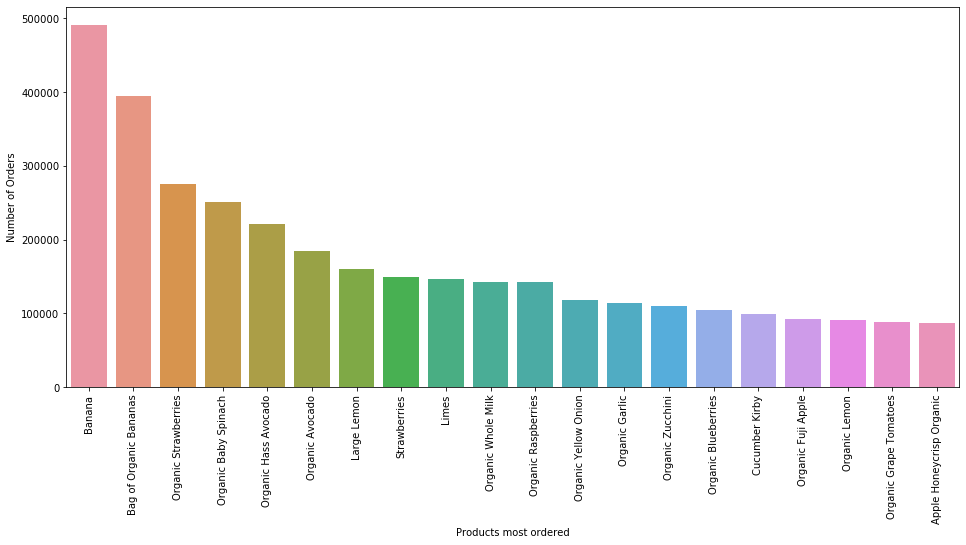

<Figure size 432x288 with 0 Axes>

In [5]:
fig_prod_bought(data, 1)


# To Do:
- Grafik beschreiben

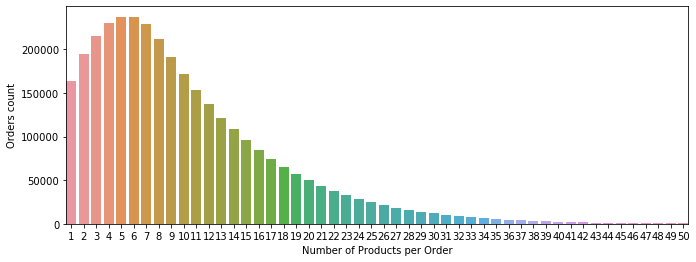

<Figure size 432x288 with 0 Axes>

In [6]:
fig_prod_per_order(data, 1)

# To Do:
- Grafik beschreiben

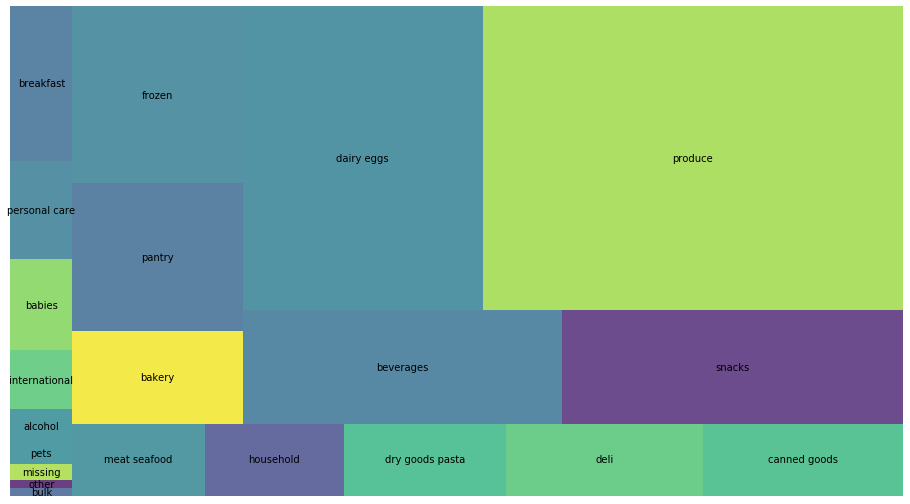

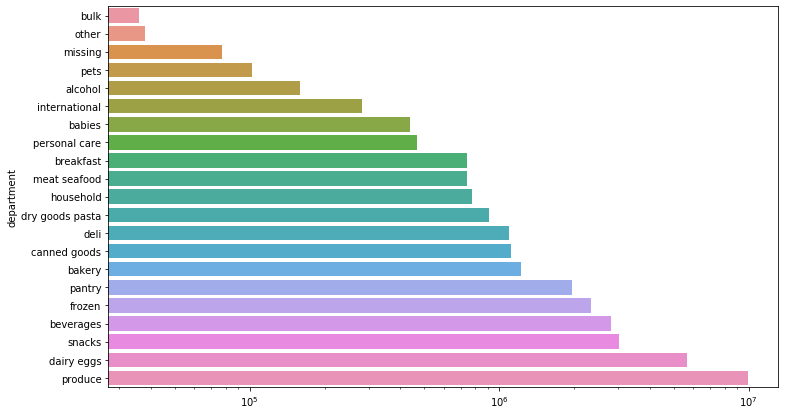

In [7]:
fig_ord_per_department(data, 0)

# To Do:
- Output beschreiben

In [8]:
# Number of Products per Department
n_p = data.groupby('department')['product_name'].value_counts()
print(n_p.head(10))

# Number of purchases per Category / Subcategory
p_c_s = data.groupby('department')['aisle'].value_counts()
print(p_c_s.head(10))

del n_p, p_c_s

department  product_name      
alcohol     Sauvignon Blanc       8541
            Cabernet Sauvignon    6352
            Chardonnay            6346
            Beer                  6068
            Vodka                 5666
            India Pale Ale        4402
            Pinot Noir            4116
            Pinot Grigio          3351
            Malbec                2542
            Chardonnay Wine       2075
Name: product_name, dtype: int64
department  aisle                     
alcohol     beers coolers                  50496
            red wines                      36424
            white wines                    31646
            spirits                        29069
            specialty wines champagnes     11659
babies      baby food formula             395654
            diapers wipes                  25714
            baby bath body care             8909
            baby accessories                8466
bakery      bread                         608469
Name: aisle, dtyp

# Datenaufbereitung

## Datenreduktion
In diesem Modul werden die Rohdaten vorbereitet bzw. gefiltert. Die Filterung der Daten kann direkten Einfluss auf die Qualität der berechneten Recommendations und besonder auch auf die Performance der Berechnungen haben. Beispielsweise ist es für User, welche eine geringe History haben, also nicht viele Produkte gekauft / bewertet haben, schwieriger passende Recommendations zu berechnen, da diese User nur ungenügend mit anderen Usern verglichen werden können. Des weiteren ist es sinnvoll, Produkte welche nur selten gekauft wurden, aus der Berechnung der Recommendations auszuschliessen, da diese vermutlich nie empfohlen werden. 

In diemse Modul wurden die folgenden Reduktionen des Datensatzen vorgenommen:

-	Ein Threshold, dass nur Produkte (Items) berücksichtigt werden welche n mal gekauft wurden
-	Ein Threshold, dass nur Kunden (Users) berücksichtigt werden, welche n Produkte gekauft haben
-	Ein Threshold, dass nur Kunden berücksichtigt werden, welche mehr als einmal eingekauft haben

Als Resultat liefert das Modul einen reduzierter Datensatz, welcher die nicht relevanten Records entfernt hat.



### Reduktion der Transaktionen auf Basis der Produkte

In der Aufgabenstellung der Challenge ist gefordert, dass der Produktekatalog um 80% redzuiert werden soll. In einem ersten Schritt, wird aufgelistet, welche Produkte wie oft gekauft wurden. Diese Liste wird sortiert nach der Häufigkeit der Verkaufszahlen. Anschliessend werden die Transaktionen gefiltert um nur noch Einträge zu berücksichtigen, welche den Top 20 Prozent der Produkte entsprechen.

Total sind im Datensatz 49685 Produkte vorhanden. Wird diese Anzahl auf 20% reduziert, bleiben noch 9937 Produkte. Gesamthaft befinden sich im Datensatz 33'819'106 Transaktionen; gefiltert auf die Top 20% der Produkte bleiben immer noch 30'749'657 Transaktionen vorhanden.

Dies führt weiter dazu, dass auch das Produkt, welches am wenigesten oft gekauft wurde, immer noch 393-mal verkauft wurde.


# To Do:
- Beschreibe Funktion
- Wieso wir das machen
- Resultate kommentieren


In [3]:
data_f = reduce_products(data, 0.2)

Product most bought: Banana    145955
Name: product_name, dtype: int64
Product least bought (top 20%): Bold Habanero BBQ Almonds    124
Name: product_name, dtype: int64


### Reduktion der Transaktionen auf Basis der User

Der Datensatz wird weiter reduziert, um nur User zu erhalten welche eine relevante Anzahl an Produkte gekauft haben. Im ersten Schritt wird aufgezeigt welche User wieviele Produkte gekauft haben. Anhand dieser Zahlen wird anschliessend eine Selektion der Top n User gemacht und die nicht benötigten aus den Transaktionen entfernt.

Annahme: Relevante User haben mindestens 30 verschiedene Produkte gekauft. (Muss vermutlich zu einem späteren Zeitpunkt noch angepasst werden)

Durch die Filterung der Transaktionen anhand der relevaten User wird der Datensatz ein weiters mal verkleiniert, es bleiben noch 28'501'910 Transaktionen

# To Do:
- Beschreibe Funktion
- Wieso wir das machen
- Resultate kommentieren
- Beschreibung funktionsname anpassen


In [4]:
data_f = reduce_users_prod(data_f, 100)

Users with most products: user_id
60694    474
15124    470
5557     465
15229    453
58965    443
dtype: int64
Users with least products: user_id
113     1
218     1
318     1
619     1
1098    1
dtype: int64


# To Do:
- Bevor der Anteil rausgelöscht wird der user müssen diese mit der funktion überprüft werden (info_order_per_user)
- --> vielleicht lohnt es sich hier ein Histogramm oder boxplot zu erstellen?

In [12]:
info_order_per_user(data_f)

count    139244.000000
mean         19.973636
std          18.243724
min           2.000000
25%           8.000000
50%          14.000000
75%          25.000000
max         100.000000
Name: order_id, dtype: float64


In [5]:
data_f = reduce_user_purch(data_f, 25)

Based on the above percentiles 75 % of users will be eliminated

## Matrixerstellung

In diesem Modul wird aus dem reduzierten Datensatz eine User-Item Matrix generiert. Hierbei besteht die Möglichkeit die Ratings nach unterschiedlichen Berechnungsmethoden zu definieren. Die folgenden zwei Ansätze wurden implementiert: 
- Unary / Binary Rating: Das Rating sagt lediglich aus, ob ein User ein Item gekauft hat (1) oder nicht (0).
- Ordinales Rating: Wert wie oft ein Produkt gekauft wurde. Dieses Rating ist jedoch nicht zwingend Aussagekräftig; Gewisse Items werden möglicherweise oft gekauft, aber nicht zwangsläufig vom User besser bewertet (z.B. WC-Papier, wird benötigt, muss aber nicht zwingend empfohlen werden)

# To Do:
- Ordinales Rating normalisieren? Momentan ist die Skala nach oben offen, da einfach die Anzahl der Käufe zusammengezählt werden


In [5]:
# Funktion für die Erstellung einer User-Item Matrix. Hierbei kann definiert werden ob die Matrix binäre Ratings enthalten soll (hat ein User ein Item gekauft / bewertet: ja oder nein) oder Anzahl (count), wie oft ein User ein Item gekauft hat.

# Erstelle Matrix mit Unary Ratings
matrix_unary = create_user_item_matrix(data_f,'unary')

# Im entsprechenden Modul "matrixerstellung.py" befindet sich zudem noch die Funktionen unary_matrix und count_matrix welche für die Matrixerstellung verwendet werden können. Da hier jedoch ein Pivottable zum Einsatz kommt, dauert dies bei grösseren Datenmengen sehr lange.

In [4]:
# Erstelle Matrix mit ordinalen Ratings 
matrix_count = create_user_item_matrix(data_f,'count')

## Split Train / Test Set

Aufteilung der Daten in Test- und Trainset respektive Maskierung von Werten. Es wurden zwei Ansätze implementiert

1. Ansatz: Zufällig N-Prozent aller User 
2. Ansatz:  N-Prozent der Ratings werden im Training Set maskiert. Das Testset enthält den vollständigen Datensatz


In [6]:
# für SVD müssen die Matrixen unterteilt werden, N% der User in die eine Matrix, der Rest in die andere Matrix
matrix_train,matrix_test = split_test_train(matrix_unary, 0.1)

In [6]:
# Für ein UBCF müssen alle Kunden im Trainingset vorhanden sein, da auf Basis dieser Daten, Ähnlichkeiten von Benutzern berechnet werden. Fehlt ein User im Trainingsset, so ist keine Berechnung der Ähnlichkeit möglich.
'''
Output ist: 
- Ein Trainset, welches dem Daten maskiert (entfernt) hat
- Ein Testset, welches die kompetten Daten enthält
- Eine Liste der User bei welchen Daten maskiert wurden
- Eine Liste der Indexe der Ratings welche maskiert wurden
'''
train_set, test_set, users_masked, index_masked = mask_test_train(matrix_unary,0.1)

# Recommender Building

In diesem Modul werden die eigentlichen Recommendations berechnet. Es wurden zwei Modelle implementiert:
- Memory-Based: User-based collaborative filtering. Hierbei wird in der User-Item Matrix nach ähnlichen Usern gesucht und Items vorgeschlagen, welche bei diesen Usern am beliebtesten sind. Die ähnlichkeit von Users wird berechnet anhand der Items welche sie bisher gekauft haben.
- Modell-Based: Die User-Item Matrix wird mittels Matrix-Faktorisierung (Single Value Decomposition) in eine User-Factor und eine Factor-Item Matrix dekomposiert.

## Memory-Based Recommender

In [7]:
# User based Collaborative Filtering
# Es werden andere Kunden (Users) gesucht, welche in der Vergangenheit ein ähnliches Kaufverhalten aufweisen. Die Ratings dieser Kunden werden verwendet um vorherzusagen, wie gut ein Produkt (Item) dem Kunden gefallen könnte.

# Berechnung der Ähnlichkeit von Usern
sim = user_sim_v3(train_set)

# Zusätzlich zu diesem Funktion befindet sich im Modul "matrixerstellung.py" auch eine user_sim, user_sim_v1 und user_sim_v2. Diese werden nicht benötigt, dienen lediglich Dokumentationszwecken.

In [9]:
# Berechnung der Nachbarschaft (Neighbourhood) auf Basis der Ähnlichkeit der User. Der Radius der Nachbarschaft kann definiert werden (zweiter Parameter der Funktion)
user_neighbours = user_hood(sim,10)

In [9]:
# Berechnung eines Ratings eines Items für einen User
# Die Funktion wird in einer späteren Funktion aufgerufen und ist hier nur zu Dokumentationszwecken aufgeführt

predict(train_set,sim,user_neighbours,10,155)

In [15]:
# Berechnung für welche Items einem User Ratings berechnet werden sollen
# Die Funktion wird in einer späteren Funktion aufgerufen und ist hier nur zu Dokumentationszwecken aufgeführt

products_to_recommend(train_set,sim,user_neighbours,1)

In [107]:
# Berechnen der Recommendations für einen User
# Input ist die user_id sowie die Anzahl Recommendations welche ausgegeben werden sollen

get_recommendations(train_set,sim,user_neighbours,10,20)

,index,item,rating
0,328,4918.0,0.441971
1,522,3344.0,0.440690
2,536,3377.0,0.438174
3,535,9518.0,0.392415
4,689,9934.0,0.370772
5,286,6881.0,0.366779
6,381,949.0,0.317092
7,235,4715.0,0.315609
8,659,9874.0,0.307708
9,43,6262.0,0.307387


## Model Based Recommender

In [ ]:
np.ravel(matrix_)

In [ ]:
U, s, VT = svd(matrix_train_count_np)

In [ ]:
print(U)
print(s)
print(VT)

In [ ]:
matrix_test_count_np 

# Evaluation
Bei der Evaluation wird das Test-Set in zwei Teile aufgeteilt (der Split geschieht im Datenverarbeitungsmodul), das Test- und das Trainingset. Hierbei befinden sich 90% der User im Trainingset. Für die Daten im Testset ist zudem zu beachten, dass es sich um User handelt welche tendenziell eine grosse Anzahl an Ratings aufweisen.  Dabei wird der Recommender mit dem Training-Set angelernt und mit dem Test-Set auf seine Leistung getestet. Bei den Usern im Testset werden einzelne Ratings entfernt (maskiert), welche dann mittels des Recommenders möglichst wieder errechnet werden. Als Beispiel:
Bei User A werden von total 40 bewerteten Items, bei 10 Items die Ratings entfernt. Anschliessend werden die Top 10 Recommendations für User A berechnet. Je grösser die Übereinstimmung der berechneten Recommendations, mit den zuvor gelöschten Items von User A ist, desto besser funktioniert der Recommender für User A. Dieser Schritt wird für sämtliche User aus dem Testset wiederholt. Der Durchschnitt aller berechneten Recommendations gegenüber ihren tatsächlichen Ratings, ergibt die Genauigkeit der Vorhersage für den verwendeten Recommender. 


In [106]:
# Berechnung von Precision@N für UBCF
# Anzahl in den Top N Recommendation enthaltenen Produkte geteilt durch die Anzahl empfohlener Produkte

'''
User-Item Matrix
Simiarities
User Neighbours
Masked Ratings
User which should be calculated
Number of Item Recommendations
'''

precision(train_set,sim,user_neighbours,index_masked,10,10)

0.1

In [112]:
# Berechnung von Recall@N für UBCF
# Anzahl in den Top N Recommendation enthaltenen Produkte / Der der maskierten Produkte

'''
User-Item Matrix
Simiarities
User Neighbours
Masked Ratings
User which should be calculated
Number of Item Recommendations
'''

recall(train_set,sim,user_neighbours,index_masked,10,10)


(0.08333333333333333, 12)

In [10]:
# Um aussagekräftige Ergebnisse zu bekommen muss ein Test N mal wiederholt werden

'''
Art des Testfalls: precision oder recall
User-Item Matrix
Simiarities
User Neighbours
Masked Ratings
How many users should be calculated / how often should the test be run
List of testusers
Number of Item Recommendations @N
'''

repeat_test('precision',train_set,sim,user_neighbours,index_masked,10,users_masked,10)


precision@10:
Average over 10 Users: 0.11000000000000001
